## Student Name : Fergus Mc Hale
## Student ID : 18203485
## Classification

In [1]:
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.decomposition import FactorAnalysis

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score


from statsmodels.nonparametric.kde import KDEUnivariate
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from pprint import pprint

In [2]:
TEST_SIZE = 0.3
CSV_SPLIT = ';'

## Training Data

# https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work

In [3]:
data = pd.read_csv('./data/Absenteeism_at_work.csv',sep=CSV_SPLIT, delimiter=None)

In [4]:
dataset = data.values

In [5]:
del data['ID']

In [6]:
X = dataset[:,1:19]
y = dataset[:,20]

In [7]:
#print("Covariance matrix:\n", np.cov(X,rowvar=False))
# Create correlation matrix
corr_mat = np.corrcoef(X,rowvar=False)
#print("\nCorrelation matrix:\n", corr_mat)

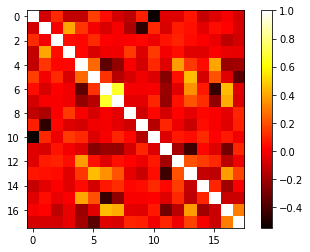

In [8]:
plt.imshow(corr_mat, cmap='hot')
plt.colorbar() 
plt.show()

In [9]:
data.head()

,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average per day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


In [10]:
data.isnull().sum().sort_values(ascending=False).head()

Absenteeism time in hours    0
Body mass index              0
Month of absence             0
Day of the week              0
Seasons                      0
dtype: int64

In [11]:
#data['Age'].value_counts()

In [12]:
#data.describe()

## Preprocessing

In [13]:
data_scaled = preprocessing.scale(data)
print("\nAFTER:")
print("Mean =", data_scaled.mean(axis=0))
print("Std deviation =", data_scaled.std(axis=0))


AFTER:
Mean = [-1.63232791e-16 -1.34427004e-16  6.72135020e-17  5.76115732e-17
 -9.12183242e-17 -3.00060277e-17 -8.16163953e-17 -4.27285834e-16
 -4.22484870e-16 -2.49650150e-16  1.92038577e-17  1.34427004e-16
 -5.76115732e-17  7.68154309e-17 -5.04101265e-17 -9.60192886e-18
 -1.44028933e-17 -9.04981795e-16  1.12822664e-16  3.00060277e-17]
Std deviation = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


/opt/tljh/user/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  """Entry point for launching an IPython kernel.


## Normalization

In [14]:
# Normalize data use l2 to find outliners
data_normalized_l1 = preprocessing.normalize(data, norm='l1')
data_normalized_l2 = preprocessing.normalize(data, norm='l2')
print("\nL1 normalized data:\n", data_normalized_l1[data_normalized_l1 != 0.])
print("\nL2 normalized data:\n", data_normalized_l2[data_normalized_l2 != 0.])


L1 normalized data:
 [0.0248672  0.00669502 0.00286929 ... 0.08137651 0.18494661 0.02642094]

L2 normalized data:
 [0.05930386 0.01596642 0.00684275 ... 0.19440308 0.44182517 0.06311788]


In [15]:
variable_names = list(data)

## http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FactorAnalysis.html

In [16]:
# Find the Main Outliners to be used 
factor = FactorAnalysis().fit(data_normalized_l2)
pd.DataFrame(factor.components_ ,columns = variable_names)
transformed_outliner_factors = factor.transform(data_normalized_l2) 
score = factor.score(data_normalized_l2)
print("Score")
print(score)
score_of_each_sample = factor.score_samples(data_normalized_l2)

Score
67.57949188669066


In [17]:
print('Outiners')
outliners = transformed_outliner_factors[transformed_outliner_factors != 0.]
print(outliners)

Outiners
[ 0.4242015  -0.99418546 -0.49961436 ...  0.42383909 -0.47450632
 -0.27414211]


In [61]:
def plot_histogram(x):
    plt.hist(x, color='blue', alpha=0.5)
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

In [19]:
def find_outliers_kde(x):
    x_scaled = scale(list(map(float, x)))
    kde = KDEUnivariate(x_scaled)
    kde.fit(bw="scott", fft=True)
    pred = kde.evaluate(x_scaled)
    
    n = sum(pred < 0.05)
    outlier_ind = np.asarray(pred).argsort()[:n]
    outlier_value = np.asarray(x)[outlier_ind]

    return outlier_ind, outlier_value

In [20]:
# Age
tukey_indices, tukey_values = find_outliers_kde(data['Age'])
print(np.sort(tukey_values))

[53 58 58 58 58 58 58 58 58]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


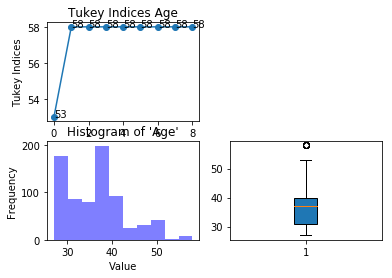

In [89]:
def plot_all(varname):
    tukey_indices, tukey_values = find_outliers_kde(data['Age'])
    x = np.arange(len(tukey_indices))
    y = np.sort(tukey_values)
    plt.subplot(2, 2, 1)
    plt.plot(x, y, 'o-')
    for i,j in zip(x,y):
        plt.annotate(str(j),xy=(i,j))
    plt.title('Tukey Indices ' +varname)
    plt.ylabel('Tukey Indices')
    plt.subplot(2, 2, 3)
    plt.hist(data[varname], color='blue', alpha=0.5)
    plt.title("Histogram of '{var_name}'".format(var_name=varname))
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.subplot(2, 2, 4)
    plt.boxplot(data['Age'],patch_artist=True, meanline=True)
    
plot_all('Age')

/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


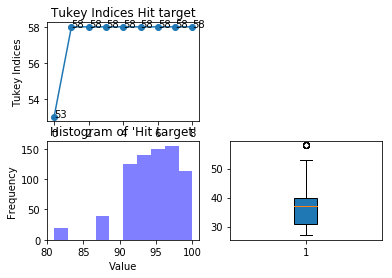

In [90]:
plot_all('Hit target')

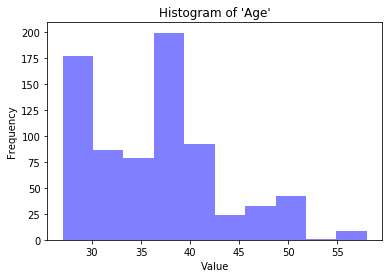

In [21]:
plot_histogram(data['Age'])

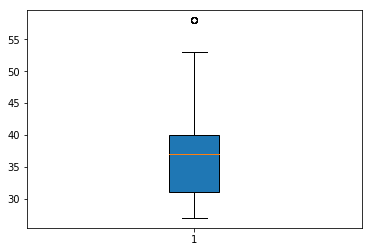

In [22]:
plt.boxplot(data['Age'],patch_artist=True, meanline=True)
plt.show()

In [23]:
# Hit Target
tukey_indices, tukey_values = find_outliers_kde(data['Hit target'])
print(np.sort(tukey_values))

[81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81 81]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


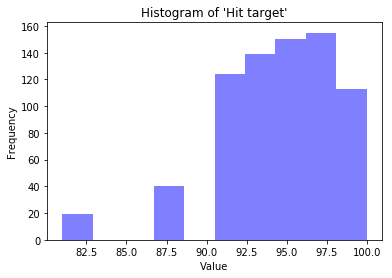

In [24]:
plot_histogram(data['Hit target'])

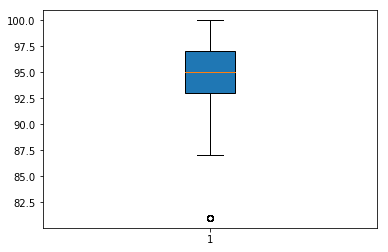

In [25]:
plt.boxplot(data['Hit target'],patch_artist=True, meanline=True)
plt.show()

In [26]:
#Service Time
tukey_indices, tukey_values = find_outliers_kde(data['Service time'])
print(np.sort(tukey_values))

[ 1  1  1  1  1  1  1 24 24 29 29 29 29 29]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


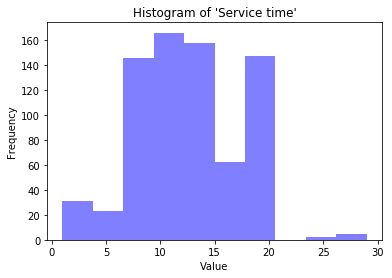

In [27]:
plot_histogram(data['Service time'])

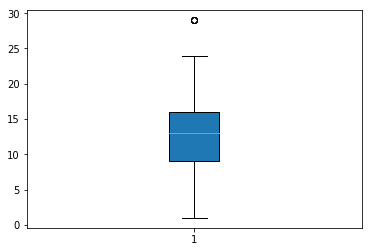

In [28]:
plt.boxplot(data['Service time'],patch_artist=True, meanline=True)
plt.show()

In [29]:
# Absenteeism time in hours
tukey_indices, tukey_values = find_outliers_kde(data['Absenteeism time in hours'])
print(np.sort(tukey_values))

[ 32  32  32  32  32  32  40  40  40  40  40  40  40  48  56  56  64  64
  64  80  80  80 104 112 112 120 120 120]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


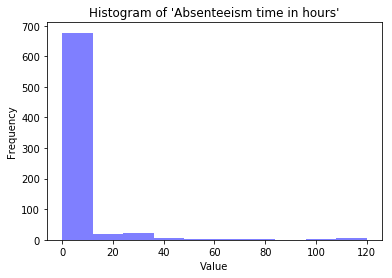

In [30]:
plot_histogram(data['Absenteeism time in hours'])

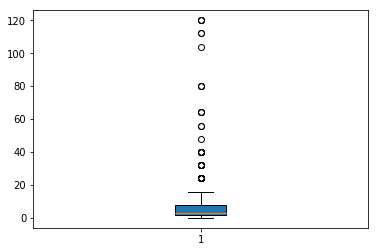

In [31]:
plt.boxplot(data['Absenteeism time in hours'],patch_artist=True, meanline=True)
plt.show()

In [32]:
# Son
tukey_indices, tukey_values = find_outliers_kde(data['Son'])
print(np.sort(tukey_values))

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


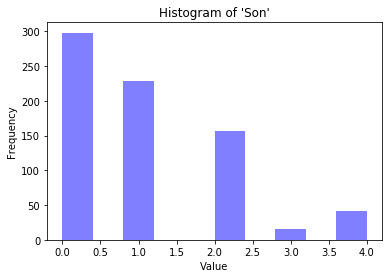

In [33]:
plot_histogram(data['Son'])

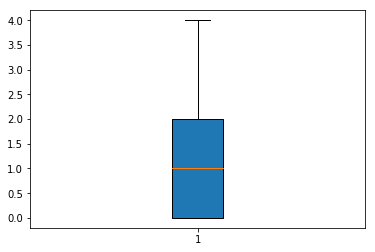

In [34]:
plt.boxplot(data['Son'],patch_artist=True, meanline=True)
plt.show()

In [35]:
# Weight
tukey_indices, tukey_values = find_outliers_kde(data['Weight'])
print(np.sort(tukey_values))

[108 108 108 108 108]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


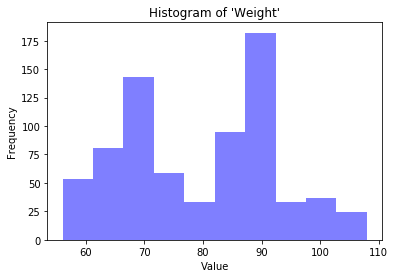

In [36]:
plot_histogram(data['Weight'])

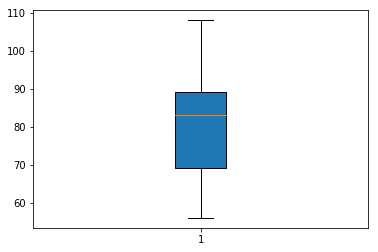

In [37]:
plt.boxplot(data['Weight'],patch_artist=True, meanline=True)
plt.show()

In [38]:
# Height
tukey_indices, tukey_values = find_outliers_kde(data['Height'])
print(np.sort(tukey_values))

[163 163 163 163 163 163 185 185 185 185 185 185 185]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [39]:
# Body Mass Index
tukey_indices, tukey_values = find_outliers_kde(data['Body mass index'])
print(np.sort(tukey_values))

[34 35 35 36 36 36 36 36 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38]


/home/jupyter-root/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


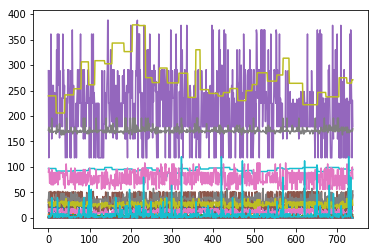

In [40]:
plt.plot(data)
plt.show()

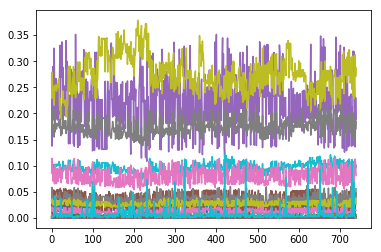

In [41]:
plt.plot(data_normalized_l1)
plt.show()

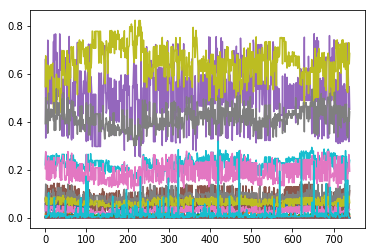

In [42]:
plt.plot(data_normalized_l2)
plt.show()

In [91]:
#pprint(outliners.tolist())

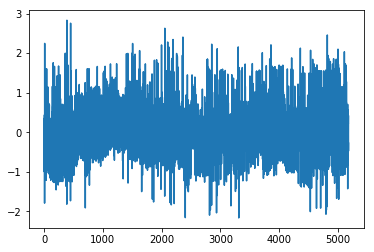

In [44]:
plt.plot(outliners)
plt.show()

In [45]:
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = TEST_SIZE, random_state = 0)

## Support Vector Machine - Linear

## http://scikit-learn.org/stable/modules/svm.html

## Training

In [92]:
classifer_train = svm.SVC(kernel='linear')
classifier_pipeline = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))

NameError: name 'make_pipeline' is not defined

In [47]:
classifer_train.fit(xTrain, yTrain) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
xTrain.shape

(518, 18)

In [49]:
yTrain.shape

(518,)

In [50]:
classifer_train.support_vectors_

array([[  0.,  11.,   3., ...,   0.,  68., 168.],
       [  0.,   3.,   5., ...,   0.,  67., 170.],
       [  0.,  11.,   3., ...,   0.,  84., 182.],
       ...,
       [ 12.,   3.,   3., ...,   1.,  65., 172.],
       [ 13.,   4.,   4., ...,   0.,  98., 178.],
       [ 11.,  11.,   2., ...,   0.,  95., 196.]])

In [51]:
classifer_train.support_

array([ 33,  38,  42,  57,  58,  80,  97, 124, 140, 163, 173, 181, 184,
       185, 189, 256, 257, 286, 304, 344, 404, 446, 500, 509,  11,  25,
        47,  59,  70,  92,  99, 110, 115, 120, 121, 128, 133, 135, 136,
       139, 153, 156, 174, 177, 179, 188, 199, 204, 211, 222, 223, 225,
       238, 250, 263, 291, 294, 296, 306, 313, 315, 330, 350, 357, 358,
       360, 368, 372, 385, 390, 391, 398, 409, 413, 423, 428, 454, 458,
       473, 480, 483, 493, 502, 506, 514,   2,   4,  13,  17,  18,  19,
        27,  31,  32,  40,  41,  46,  53,  54,  78,  79,  81,  82, 102,
       105, 107, 108, 114, 117, 127, 132, 138, 144, 146, 147, 149, 155,
       157, 167, 169, 176, 178, 196, 197, 201, 207, 213, 226, 237, 242,
       245, 255, 259, 262, 272, 273, 280, 282, 283, 284, 287, 290, 293,
       302, 314, 321, 325, 326, 327, 328, 337, 338, 340, 351, 354, 359,
       363, 366, 374, 378, 379, 384, 388, 406, 407, 410, 411, 420, 421,
       424, 425, 435, 450, 455, 459, 463, 469, 471, 486, 487, 49

In [52]:
classifer_train.n_support_

array([ 24,  61,  99,  84,  48,   5,   1, 121,  13,  10,   2,   6,   1,
         2,   1,   2,   1,   2,   2], dtype=int32)

In [53]:
clf_predictions = classifer_train.predict(xTest)
print("Accuracy: {}%".format(classifer_train.score(xTest, yTest) * 100 ))

Accuracy: 43.69369369369369%


## Testing

In [54]:
classifer_test = svm.SVC(kernel='linear')

In [55]:
classifer_test.fit(xTest, yTest)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [56]:
classifer_test.support_vectors_

array([[  0.,   9.,   3., ...,   0.,  98., 178.],
       [  0.,  10.,   3., ...,   0.,  75., 185.],
       [  0.,   7.,   3., ...,   0.,  98., 178.],
       ...,
       [  1.,  10.,   4., ...,   0.,  56., 171.],
       [ 13.,   6.,   4., ...,   0.,  98., 178.],
       [  6.,   7.,   3., ...,   1.,  65., 172.]])

In [57]:
classifer_test.support_

array([ 12,  25,  41,  67,  83,  93,  96,  98, 102, 124, 130, 153, 185,
       194,  37,  52,  53,  63,  66,  70,  80, 104, 110, 116, 127, 128,
       138, 157, 160, 165, 179, 182, 188, 189, 198, 200, 205, 209, 216,
         5,  10,  17,  21,  29,  31,  45,  48,  51,  54,  61,  76,  87,
        89, 131, 132, 133, 136, 139, 141, 150, 155, 156, 161, 167, 173,
       181, 183, 187, 202, 203, 206, 208, 212, 213, 214, 215,  13,  14,
        19,  20,  23,  26,  34,  43,  44,  56,  57,  62,  69,  88, 100,
       103, 105, 109, 114, 145, 147, 158, 164, 166, 171, 184, 193,   2,
         9,  15,  22,  35,  68,  78,  92, 120, 195, 211, 218, 168, 191,
         0,   3,   7,   8,  11,  18,  24,  27,  32,  33,  36,  38,  40,
        47,  55,  58,  59,  71,  72,  73,  74,  79,  81,  84,  86,  90,
        94,  95,  97, 111, 112, 115, 118, 119, 121, 122, 134, 135, 137,
       143, 146, 148, 152, 154, 169, 172, 174, 175, 177, 180, 186, 190,
       192, 196, 199, 210, 217, 219, 221,   6, 140, 149, 176, 20

In [58]:
classifer_test.n_support_

array([14, 25, 37, 27, 12,  2, 59,  6,  6,  4,  1,  2,  1,  1],
      dtype=int32)

In [59]:
clf_predictions = classifer_test.predict(xTest)
print("Accuracy: {}%".format(classifer_test.score(xTest, yTest) * 100 ))

Accuracy: 75.67567567567568%


In [60]:
# Provided By Cormac Lavery
predictions = regr.predict(xTest)
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest, alpha=.5, label="actual")
plt.plot(predictions, alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

sorted_indexs = yTest.argsort()
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest[sorted_indexs], alpha=.5, label="actual")
plt.plot(predictions[sorted_indexs], alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

NameError: name 'regr' is not defined

## Grid Search CV

## http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

In [ ]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']}

In [ ]:
def rmsle(y_predicted, y_real):
    return np.sqrt(np.mean(np.power(np.log1p(y_predicted)-np.log1p(y_real), 2)))
def procenterror(y_predicted, y_real):
     return np.round( np.mean(np.abs(y_predicted-y_real) )/ np.mean(y_real) *100 ,1)

## Training

In [ ]:
grid_search_train =  GridSearchCV(svm.SVC(),param_grid, refit = True, verbose = 1)

In [ ]:
grid_search_train_regr = grid_search_train.fit(xTrain,yTrain)

In [ ]:
print("Grid Search CV",'%error',procenterror(grid_search_train_regr.predict(xTrain),yTrain),'rmsle',rmsle(grid_search_train_regr.predict(xTrain),yTrain))

In [ ]:
print("Grid Search",'Classification Report')
classif=classification_report(yTrain,np.round(regr.predict(xTrain)))
print(classif)

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(yTrain,np.round(regr.predict(xTrain))) * 100,2)
print('Accuracy', logreg_accuracy,'%')

In [ ]:
grid_search_test =  GridSearchCV(svm.SVC(),param_grid, refit = True, verbose = 1)

In [ ]:
grid_search_test_regr = grid_search_train.fit(xTest,yTest)

In [ ]:
print("Grid Search CV",'%error',procenterror(grid_search_test_regr.predict(xTest),yTest),'rmsle',rmsle(grid_search_test_regr.predict(xTest),yTest))

In [ ]:
print("Grid Search",'Classification Report')
classif=classification_report(yTest,np.round(regr.predict(xTest)))
print(classif)

# Accuracy
print('--'*40)
logreg_accuracy = round(accuracy_score(yTest,np.round(regr.predict(xTest))) * 100,2)
print('Accuracy', logreg_accuracy,'%')

## Linear Regression

In [ ]:
# Provided By Cormac Lavery
regression = LinearRegression()
regression.fit(xTrain, yTrain)
predictions_regression = regression.predict(xTest)

plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest, alpha=.5, label="actual")
plt.plot(predictions_regression, alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

sorted_indexs = yTest.argsort()
plt.xlabel("sample #")
plt.ylabel("absent hours")
plt.plot(yTest[sorted_indexs], alpha=.5, label="actual")
plt.plot(predictions_regression[sorted_indexs], alpha=.5, label="prediction")
plt.legend(loc='upper left')
plt.show()

print("regression model stats")
print(mean_squared_error(yTest, predictions_regression))
print(r2_score(yTest, predictions_regression))

print("classification model stats based on linear accuracy")
print(mean_squared_error(yTest, predictions))
print(r2_score(yTest, predictions))

In [ ]:
# References
# https://www.learnopencv.com/svm-using-scikit-learn-in-python/
# https://www.kaggle.com/plarmuseau/ten-100-correct-models#
# http://www.datasciencemadesimple.com/box-plot-in-python/
# https://www.youtube.com/watch?v=0pP4EwWJgIU
# https://fizzylogic.nl/2017/11/07/learn-how-to-build-flexible-machine-learning-pipelines-in-sklearn/
# https://www.youtube.com/watch?v=URdnFlZnlaE
# http://tullo.ch/articles/svm-py/ 